# Deep Reinforcement Lerning Lectures - Policy Gradients

### Imports and auxiliary settings

In [1]:
!apt update
!apt install -y xvfb x11-utils python-opengl ffmpeg
!pip install gym==0.17.3 pyvirtualdisplay
!pip install box2d-py
!pip install onnx onnxruntime
!pip install gym[Box_2D]

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease    
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease            
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease    
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease          
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://develope

In [2]:
# select device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

# Auxiliary Python imports
import onnx
import io
import glob
import copy
import base64
import random
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

# Environment import and set logger level to display error only
import gym; gym.logger.set_level(40)
from gym.wrappers import Monitor

# Plotting and notebook imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import HTML, display, clear_output
from torch.utils.tensorboard import SummaryWriter

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()
summarywriter = SummaryWriter(log_dir="logs")

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Auxiliary Methods

In [5]:
def wrap_env(env):
    # wrapper for recording
    env = Monitor(env, './video', force=True)
    return env


def create_env(env_id='BipedalWalker-v3'):
    # initialize environment
    env = wrap_env(gym.make(env_id))
    action_size = env.action_space.shape[0]
    state_size = env.observation_space.shape[0]
    return env, action_size, state_size


def set_seed(env, seed=None):
    # seeding the envrionment
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


def transforms(state):
    # transofrm to numpy to tensor and push to device
    return torch.FloatTensor(state).to(device)

            
def test_environment(env, agent=None, n_steps=200):
    # run and evaluate in the environment
    state = env.reset()
    for i in range(n_steps):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = np.clip(action.squeeze().cpu().numpy(), -1, 1)
        state, reward, done, info = env.step(action)
        if done:
            env.reset()
    env.close()


def get_running_stat(stat, stat_len):
    # evaluate stats
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner, reward_scale=lambda x: x):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)
    
    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
   
    plt.subplot(322)
    
    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    
    plt.subplot(323)
    
    # plot return
    all_returns = np.array(runner.buffer.all_returns)/reward_scale
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)/reward_scale # rescale back to original return
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')
    
    plt.subplot(324)
    
    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    if runner.logger.debug:
        # plot variance
        variance_arr = np.array(runner.logger.compute_gradient_variance())
        plt.plot(range(0, len(variance_arr)), variance_arr)
        plt.xlabel('Episode')
        plt.ylabel('Variance')
    
    plt.show()


"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def grad_variance(g):
    # compute gradient variance
    return np.mean(g**2) - np.mean(g)**2


class Logger(object):
    """Logger that can be used for debugging different values
    """
    def __init__(self, debug=False):
        self.gradients = []
        self.debug = debug

    def add_gradients(self, grad):
        if not self.debug: return
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gym` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as BipedalWalker-v3.
To access the Box2D packages, make sure you have installed gym via `pip install gym` and the Box2D simulator via `pip install box2d box2d-kengz` command in the terminal in advance.

In [6]:
# show behavior in envrionment with random agent
env, _, _ = create_env()
test_environment(env)
show_video()

### Training Buffer

In [7]:
class Transition(object):
    """Transition helper object
    """
    def __init__(self, state, action, reward, next_state, log_probs):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.g_return = 0.0
        self.log_probs = log_probs


class Episode(object):
    """Class for collecting an episode of transitions
    """
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1
        
    def states(self):
        return [s.state for s in self.transitions]
    
    def actions(self):
        return [a.action for a in self.transitions]
    
    def rewards(self):
        return [r.reward for r in self.transitions]

    def next_states(self):
        return [s_.next_state for s_ in self.transitions]
    
    def returns(self):
        return [r.g_return for r in self.transitions]
    
    def calculate_return(self):
        # calculate the return of the episode
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + discount*g_return
            return_array[i] = g_return
            self.transitions[i].g_return = g_return
        return return_array


class BufferDataset(Dataset):
    """Buffer dataset used to iterate over buffer samples when training.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        return t.state, t.action, t.reward, t.next_state, t.log_probs


class ReplayBuffer(object):
    # ===================================================
    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
    # ===================================================
    # > feel free to optimize sampling and buffer handling
    # ===================================================
    """Buffer to collect samples while rolling out in the envrionment.
    """
    def __init__(self, capacity, batch_size, min_transitions):
        self.capacity = capacity
        self.batch_size = batch_size
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []
        
    def _empty(self):
        # empty the buffer
        del self.buffer[:]
        self.position = 0

    def add(self, episode):
        # Saves a transition
        episode.calculate_return()
        for t in episode.transitions:
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[int(self.position)] = t
            self.position = (self.position + 1) % self.capacity
            
    def update_stats(self):
        # update the statistics on the buffer
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        # calls empty
        self._empty()

    def create_dataloader(self):
        # creates a dataloader for training
        train_loader = DataLoader(
            BufferDataset(self.buffer),
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader

    def __len__(self):
        return len(self.buffer)

### Define Models

In [8]:
class ActorNet(nn.Module):
    """Actor network (policy)
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) find a suitable architecture for the actor
        # ===================================================
        self.state_size = state_size
        self.dense1 = nn.Linear(state_size, hidden_size).float()
        self.dense2 = nn.Linear(hidden_size, hidden_size).float()
        self.mean_head = nn.Linear(hidden_size, action_size).float()
        self.sigma_head = nn.Sequential(
            nn.Linear(hidden_size, action_size).float(),
            nn.ReLU(True)
        )
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)

    def forward(self, x):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) compute mu and sigma logit estimates
        # ===================================================
        x = x.to(device).float()
        h = torch.relu(self.norm(self.dense1(x)))
        h = torch.relu(self.norm(self.dense2(h)))
        mu = self.mean_head(h)
        sigma_logits = self.sigma_head(h)
        return mu, sigma_logits


class CriticNet(nn.Module):
    """Critic network computing the state value
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) find a suitable architecture for the critic
        # ===================================================
        self.dense1 = nn.Linear(state_size, hidden_size).float()
        self.dense2 = nn.Linear(hidden_size, hidden_size).float()
        self.value = nn.Linear(hidden_size, 1).float()
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)

    def forward(self, x):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) compute the value estimates
        # ===================================================
        x = x.to(device).float()
        h = torch.relu(self.norm(self.dense1(x)))
        h = torch.relu(self.norm(self.dense2(h)))
        value = self.value(h)
        return value


class ActorCriticNet(nn.Module):
    """Combining both networks and add helper methods to act and evaluate samples.
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorCriticNet, self).__init__()
        self.actor = ActorNet(state_size, action_size, hidden_size)
        self.critic = CriticNet(state_size, action_size, hidden_size)

    def forward(self, x):
        x = x.reshape(1, -1)
        return self.act(x)

    def act(self, state):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) get mean and sigma logits
        # 2) softplus the sigma logits to ensure only positive values (add some eps value to avoid 0 probabilities)
        # 3) create a distribution based on mu and sigma
        # 4) sample from the distribution
        # 5) get log probabilities 
        # ===================================================
        mu, sigma_logits = self.actor(state)
        sigma = F.softplus(sigma_logits)
        distr = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.diag_embed(sigma))
        action = distr.sample()
        log_probs = distr.log_prob(action)
        # normal = torch.distributions.normal.Normal
        # distros = [normal(mean[:, i], sigma[:, i]) for i in range(mean.shape[-1])]
        # action = torch.hstack([distr.sample().unsqueeze(1) for distr in distros])
        # log_probs = torch.hstack([distros[i].log_prob(action[:, i]) for i in range(len(distros))])
        return action, log_probs

    def evaluate(self, state, action):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) get mean and sigma logits
        # 2) softplus the sigma logits to ensure only positive values (add some eps value to avoid 0 probabilities)
        # 3) create a distribution based on mu and sigma
        # 4) get log probabilities 
        # 5) get entropy from the distribution
        # 6) evaluate state value
        # ===================================================
        mu, sigma_logits = self.actor(state)
        sigma = F.softplus(sigma_logits)
        # normal = torch.distributions.normal.Normal
        # distros = [normal(mean[:, i], sigma[:, i]) for i in range(mean.shape[-1])]
        # action = torch.hstack([distr.sample().unsqueeze(1) for distr in distros])
        # log_probs = torch.hstack([distros[i].log_prob(action[:, i]) for i in range(len(distros))])
        # entropy = torch.hstack([distr.entropy().unsqueeze(1) for distr in distros])
        distr = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.diag_embed(sigma))
        log_probs = distr.log_prob(action)
        entropy = distr.entropy()
        state_value = self.critic(state)
        return state_value, log_probs, entropy

### Define Agent

In [9]:
class Agent(object):
    """Agent class used for training, saving data and handling the model.
    """
    def __init__(self, buffer, state_size, action_size, hidden_size, learning_rate, logger, eps_clip, n_epochs,
                 weight_decay, betas, loss_scales, discount, checkpoint_dir="ckpts"):
        self.action_size = action_size
        self.state_size = state_size
        self.buffer = buffer
        self.checkpoint_dir = checkpoint_dir
        self.model = ActorCriticNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
        self.loss_scales = loss_scales
        self.n_epochs = n_epochs
        self.eps_clip = eps_clip
        self.logger = logger
        self.discount = discount
        self.mse = nn.MSELoss()

    def save_checkpoint(self, epoch, info=''):
        """Saves a model checkpoint"""
        state = {
            'info': info,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        ckp_name = 'best-checkpoint.pth' if info == 'best' else f'checkpoint-epoch{epoch}.pth'
        filename = os.path.join(self.checkpoint_dir, ckp_name)
        torch.save(state, filename)

    def resume_checkpoint(self, resume_path):
        """Resumes training from an existing model checkpoint"""
        print("Loading checkpoint: {} ...".format(resume_path))
        checkpoint = torch.load(resume_path)
        # load architecture params from checkpoint.
        self.model.load_state_dict(checkpoint['state_dict'])
        # load optimizer state from checkpoint only when optimizer type is not changed.
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded. Resume training")

    def save_onnx_checkpoint(self, epoch, info=''):
        """Create an ONNX checkpoint"""
        dummy_input = torch.randn((1, self.state_size))
        dummy_input_t = transforms(dummy_input)
        model = self.model.actor.to(device)
        torch.onnx.export(model, dummy_input_t, f"{info}submission_actor_{epoch}.onnx", verbose=False, opset_version=10, export_params=True, do_constant_folding=True)

    def check(self, file_name):
        # Load the ONNX model
        model = onnx.load(file_name)
        # Check that the IR is well formed
        onnx.checker.check_model(model)

    @torch.no_grad()
    def act(self, state):
        # ===================================================
        # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
        # ===================================================
        # 1) prepare state tensors
        # 2) check if shape is ok or expand acordingly
        # 3) get action and log probabilities
        # ===================================================
        if type(state) == np.ndarray:
            state = torch.from_numpy(state)
        action, log_probs = self.model.act(state)
        return action, log_probs

    def train(self):
        for i in range(self.n_epochs):   
            # create the a dataloader based on the current buffer
            loader = self.buffer.create_dataloader()
            # iterate over the samples in the dataloader
            for states, actions, rewards, next_states, old_log_probs in loader:
                # create tensors
                state_t = states.float().to(device).detach()
                action_t = actions.to(device).detach()
                reward_t = rewards.float().view(-1, 1).to(device).detach()
                next_state_t = next_states.float().to(device).detach()
                old_log_probs_t = old_log_probs.to(device).detach()
                reward_t = (reward_t - reward_t.mean()) / reward_t.std()
                # ===================================================
                # ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
                # ===================================================
                # 1) compute target value with next state and reward
                # 2) compute advantage function from target and current state and action
                # 3) compute importance sampling ratio from log probabilities
                # 4) compute surrogate loss with the advantage and clipped surrogate loss
                # 5) compute value losses
                # 6) compute total loss with entropy regularization
                # 7) compute gradients and perform optimization step
                # ===================================================
                target = reward_t + self.discount * self.model.critic(next_state_t).detach()
                state_value, log_probs, entropy = self.model.evaluate(state_t, action_t)
                entropy_loss = -entropy.view(-1, 1)
                advantage = target - state_value
                ratio = torch.exp(log_probs.view(-1, 1) - old_log_probs_t.view(-1, 1))
                policy_loss = -torch.minimum(ratio * advantage,
                                            torch.clip(ratio,
                                                    1 - self.eps_clip,
                                                    1 + self.eps_clip)*advantage
                                           )
                # value_loss = F.mse_loss(target, state_value)
                # print("target : ", target.shape)
                # print("state_value : ", state_value.shape)
                value_loss = self.mse(target, state_value)
                # print("action_t : ", action_t.shape)
                # print("log_probs : ", log_probs.shape)
                # print("old_log_probs : ", old_log_probs_t.shape)
                # print("ratios : ", ratio.shape)
                # print("advantage : ", advantage.shape)
                # print("value_loss : ", value_loss.shape)
                # print("policy_loss : ", policy_loss.shape)
                # print("entropy : ", entropy.shape)
                loss =  (+ self.loss_scales[0] * policy_loss 
                         + self.loss_scales[1] * value_loss 
                         + self.loss_scales[2] * entropy_loss
                ).mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        # return losses and entropy
        return (loss.mean().detach().cpu().numpy(), 
                value_loss.mean().detach().cpu().numpy(), 
                policy_loss.mean().detach().cpu().numpy()), entropy.mean().detach().cpu().numpy()

### Define Task Runner

In [10]:
class Runner(object):
    """Runner class performing the rollout in the environment and calling the agent training function periodically
    """
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=5000, reward_scale=lambda x: x,
                 use_buffer_reset=True, stats_interval=1, print_stats=True, min_average_reward=300, render=False, 
                 checkpoint_interval=100, summarywriter=summarywriter):
        self.env = env
        self.agent = agent
        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        # store stats for plotting
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        # stats for running episodes
        self.timesteps = 0
        self.checkpoint_interval = checkpoint_interval
        self.best_model = None
        self.max_reward = -np.inf
        self.summarywriter = summarywriter

    def run(self):
        self.agent.model.eval()
        # train for n episodes
        rewards_all = []
        lengths = []
        losses_all = []
        policy_all = []
        value_all = []
        policy_all = []
        entropy_all = []
        with tqdm(range(self.n_episodes)) as pbar:
            for e in pbar:
                run_length = 0
                # reset env and stats
                state = torch.from_numpy(self.env.reset())
                total_losses = 0.
                value_losses = 0.
                policy_losses = 0.

                # create new episode
                episode = Episode(discount=self.discount)

                # save model
                if e % self.checkpoint_interval == 0:
                    self.agent.save_checkpoint(e)

                done = False
                # train in each episode until episode is done
                while not done:
                    self.timesteps += 1
                    # render env 
                    if self.render: self.env.render()

                    # select an action from the agent's policy
                    action, log_probs = self.agent.act(state)

                    # enter action into the env
                    act = action.cpu().squeeze().numpy()
                    next_state, reward, done, _ = self.env.step(act)
                    # collect reward
                    episode.total_reward += reward
                    # perform reward rescaling
                    reward = self.reward_scale(reward)
                    
                    # store agent transition to the episode
                    transition = Transition(state=state, action=action, reward=reward, next_state=next_state, log_probs=log_probs)
                    episode.append(transition)

                    # ===================================================
                    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
                    # ===================================================
                    # > feel free to optimize the rollout / training loop
                    # ===================================================
                    # update stats and update agent if done
                    run_length += 1
                    if done:
                        # add current episode to the replay buffer
                        self.buffer.add(episode)
                        # update stats
                        self.stats_rewards_list.append((e, episode.total_reward, episode.size()))

                        # skip if stored episodes are less than the batch size
                        if len(self.buffer) < self.buffer.min_transitions: break

                        # update the network
                        self.agent.model.train()
                        (total_loss, value_loss, policy_loss), entropy = self.agent.train()
                        self.agent.model.eval()
                        policy_all.append(policy_loss)
                        
                        # update stats
                        total_losses += total_loss
                        value_losses += value_loss
                        policy_losses += policy_loss
                        rewards_all.append(episode.total_reward)
                        lengths.append(run_length)
                        losses_all.append(total_loss)
                        entropy_all.append(entropy)
                        policy_all.append(policy_loss)
                        value_all.append(value_loss)
                        self.stats_entropy_list.append(entropy)
                        self.buffer.update_stats()
                        
                        # reset the buffer
                        if self.use_buffer_reset: self.buffer.reset()
                        # update the progress bar
                        if self.print_stats and e % self.stats_interval == 0:
                            pbar.set_description("[%03d] Reward: %.4f" % (e, np.mean(self.stats_rewards_list[-self.stats_interval:],axis=0)[1]))
                    
                    state = torch.from_numpy(next_state)
                # self.summarywriter.add_scalar("total_reward", episode.total_reward, e)
                # self.summarywriter.add_scalar("run_length", run_length, e)
                # self.summarywriter.add_scalar("total_losses", total_loss, e)
                if e % 100 == 0 and e != 0:
                  fig, ax = plt.subplots(2, 3)
                  fig.set_figheight(12)
                  fig.set_figwidth(20)
                  ax[0, 0].title.set_text("total_rews")
                  ax[0, 1].title.set_text("lengths")
                  ax[0, 2].title.set_text("tot_losses")
                  ax[0, 0].plot(rewards_all)
                  ax[0, 1].plot(lengths)
                  ax[0, 2].plot(losses_all)
                  ax[1, 0].title.set_text("value_loss")
                  ax[1, 1].title.set_text("policy_loss")
                  ax[1, 2].title.set_text("entropy")
                  ax[1, 0].plot(value_all)
                  ax[1, 1].plot(policy_all)
                  ax[1, 2].plot(entropy_all)
                  plt.pause(0.0001)

                # save best model
                if self.best_model is None or episode.total_reward > self.max_reward:
                    self.best_model = copy.deepcopy(self.agent.model)
                    self.agent.save_checkpoint(e, 'best')
                    self.max_reward = episode.total_reward

### Train Agent

In [11]:
# create environment
env, action_size, state_size = create_env()

seed = 31
# set seed
set_seed(env, seed=seed)

# ===================================================
# ++++++++++++++++ YOUR CODE HERE +++++++++++++++++++
# ===================================================
# > find suitable hyperparameters
# hyperparameters
episodes = 1000 # run agent for this many episodes
epochs = 10 # run n epochs of network updates
hidden_size = 64 # number of units in NN hidden layers
learning_rate = 1e-3 # learning rate for optimizer
discount = 0.99 # discount factor gamma value
# reward_scale = lambda x: (x - x.mean(-1))/x.std(-1) # reward scaling
reward_scale = lambda x: x
batch_size = 128 # number of samples used for an update
min_transitions = 2000 # number of minimum transitions until update is triggered
capacity = 2000 # maximum number of transitions stored in the replay buffer

use_buffer_reset = True # resets the buffer after every update
eps_clip = 0.2 # clipping or importance sampling updates
loss_scales = (.5, 1, .01) # loss scales (value loss, policy loss, entropy loss)
betas = (0.9, 0.999) # optimizer beta parameters
weight_decay = 1e-3 # optimizer weight decay
checkpoint_interval = 100 # checkpoint interval to overwrite the parameters
# ===================================================

# additional settings
print_stats = True
render = False

In [12]:
logger = Logger()
buffer = ReplayBuffer(capacity=capacity, batch_size=batch_size, min_transitions=min_transitions)
agent = Agent(buffer=buffer, state_size=state_size, action_size=action_size, hidden_size=hidden_size,
              learning_rate=learning_rate, logger=logger, eps_clip=eps_clip, n_epochs=epochs, weight_decay=weight_decay, betas=betas, loss_scales=loss_scales, discount=discount)
runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger, discount=discount, n_episodes=episodes, reward_scale=reward_scale, 
                use_buffer_reset=use_buffer_reset, print_stats=print_stats, render=render)
summarywriter = SummaryWriter(log_dir="logs")

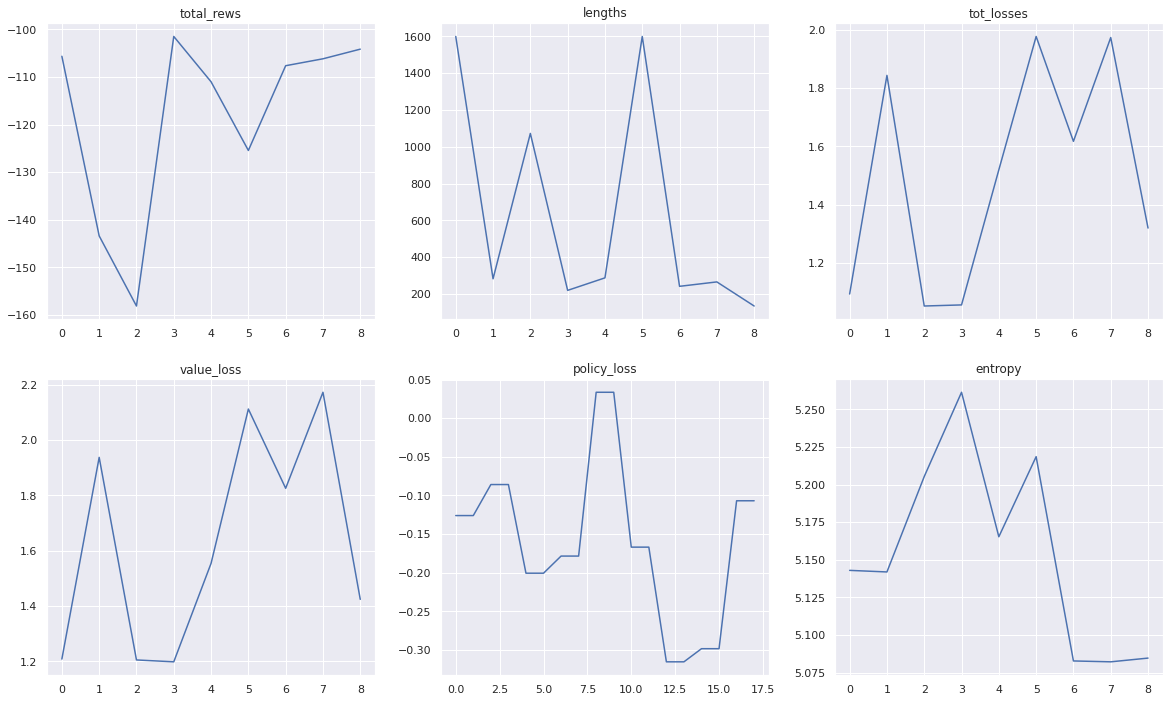

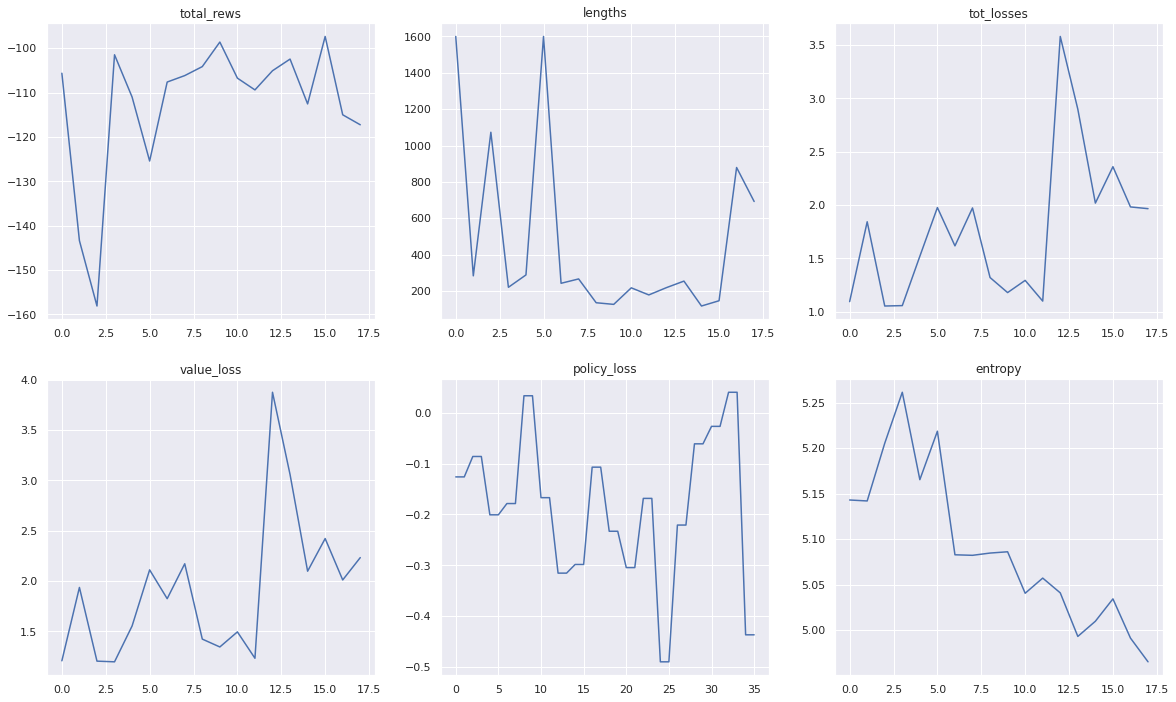

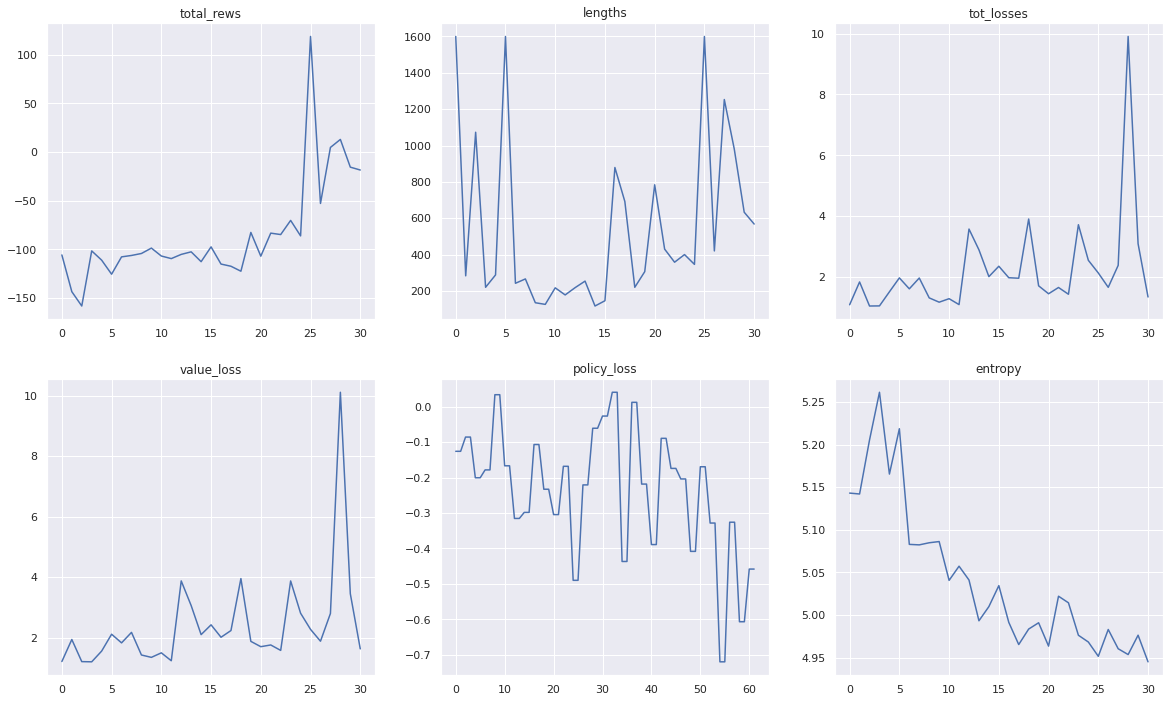

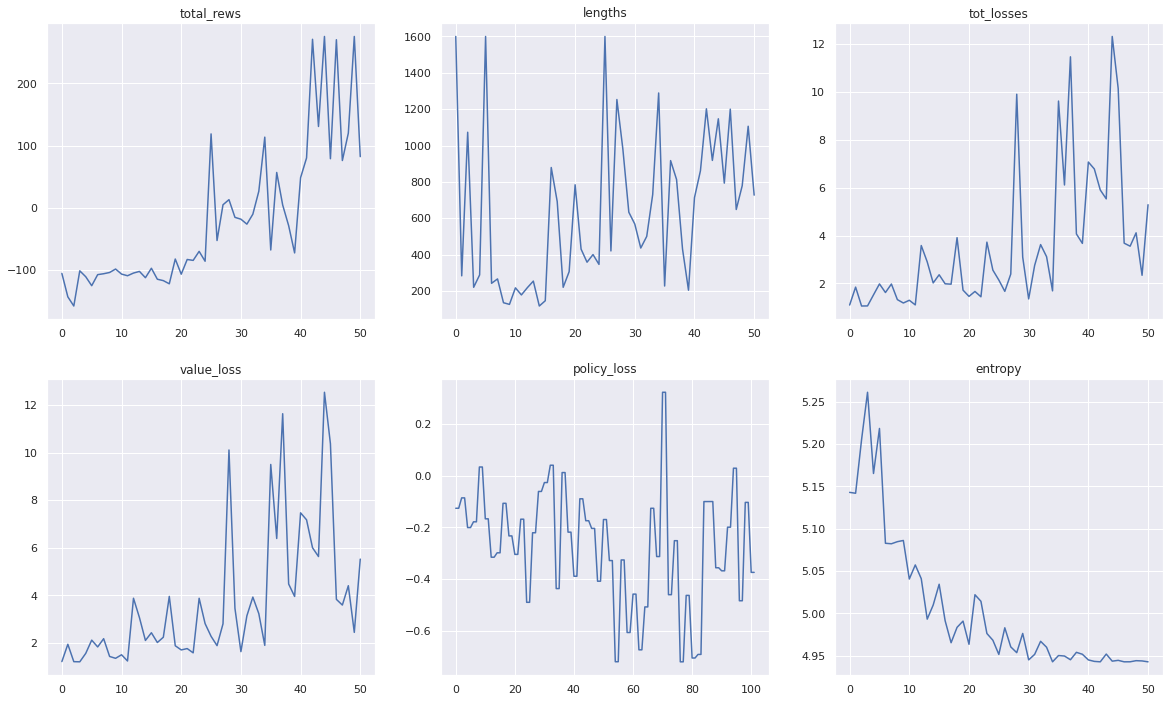

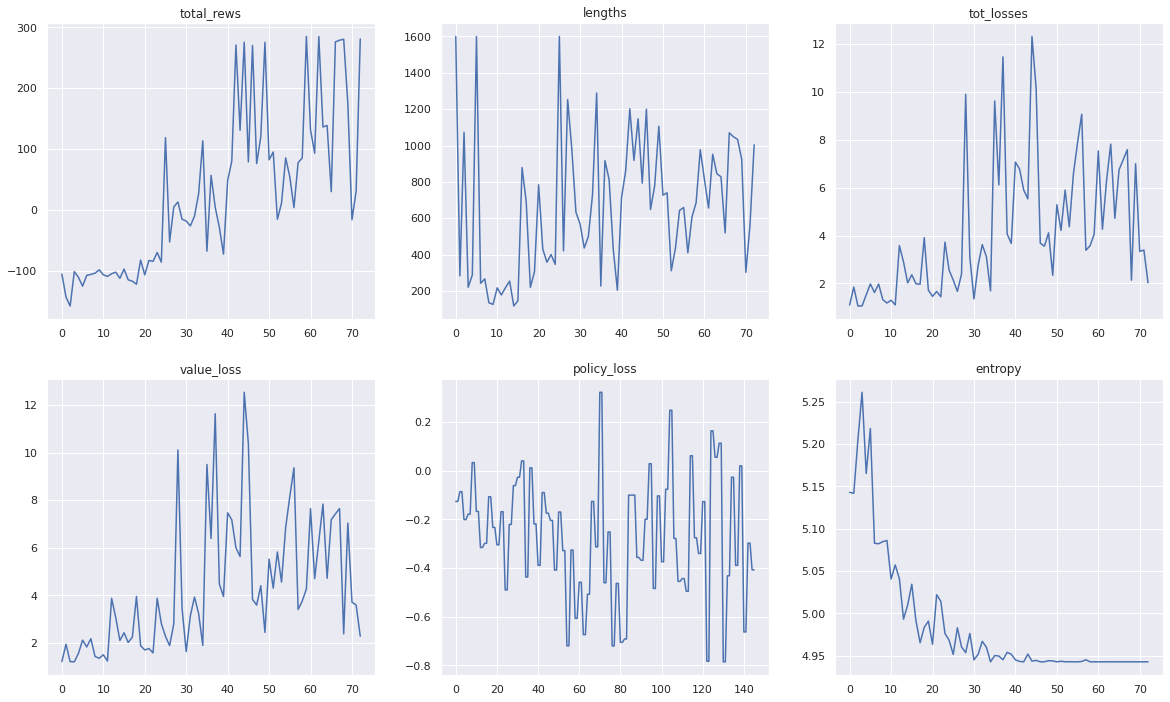

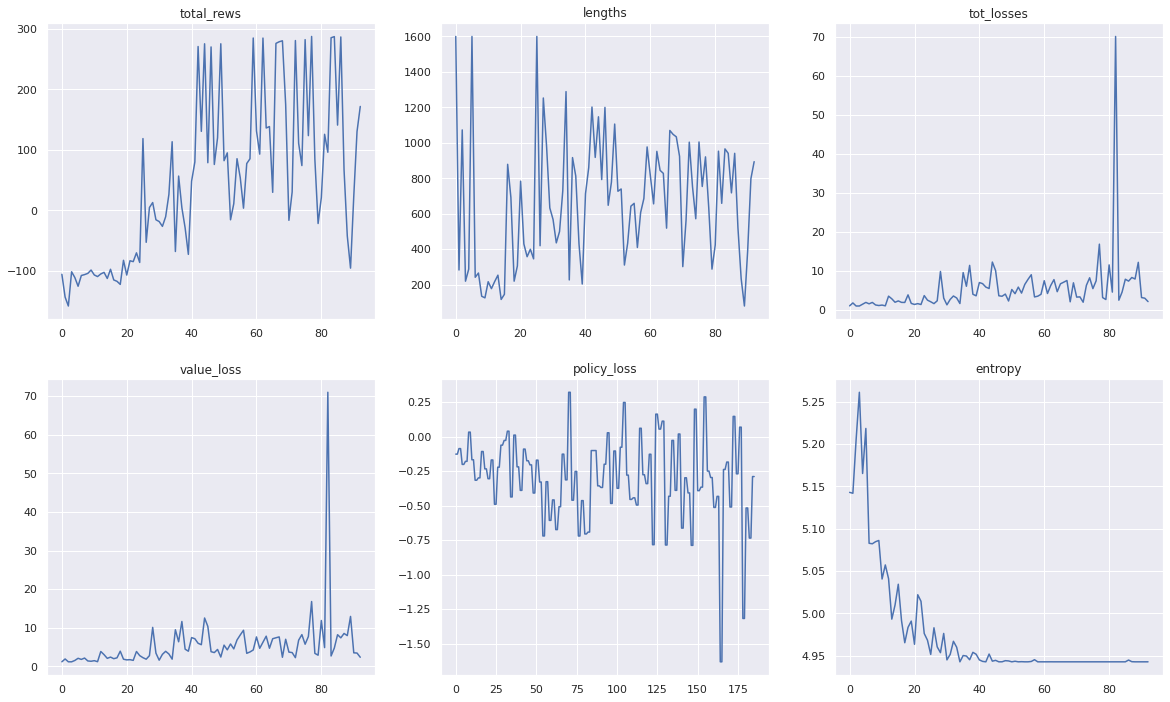

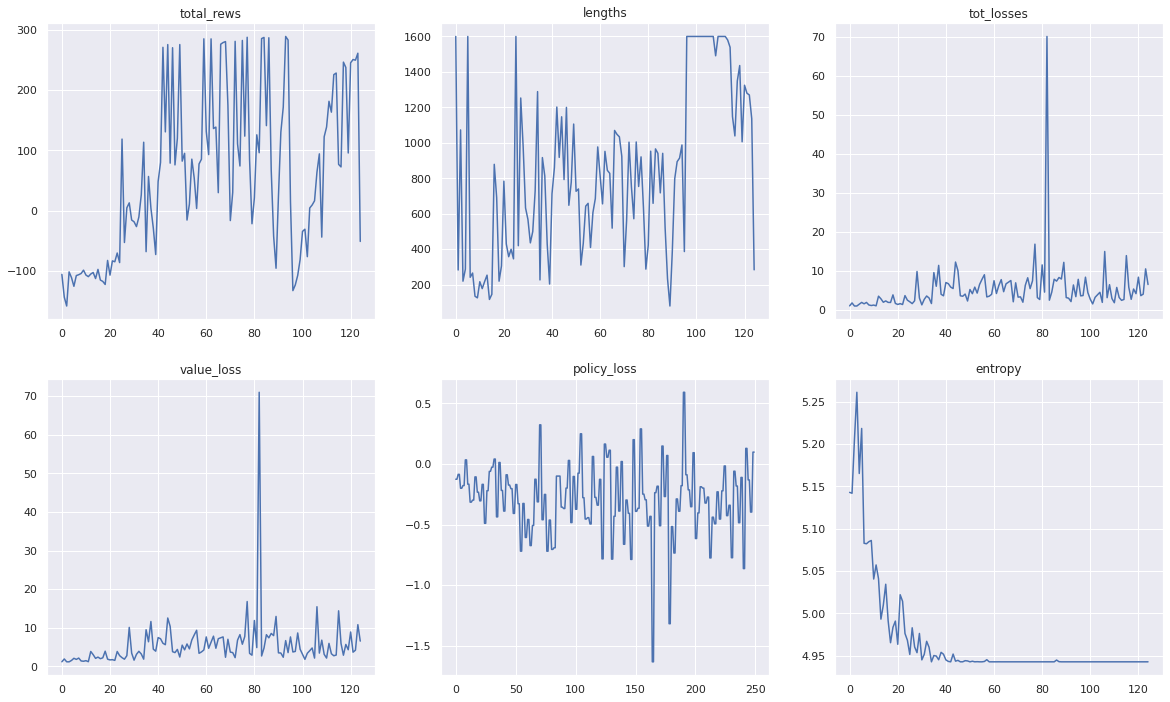

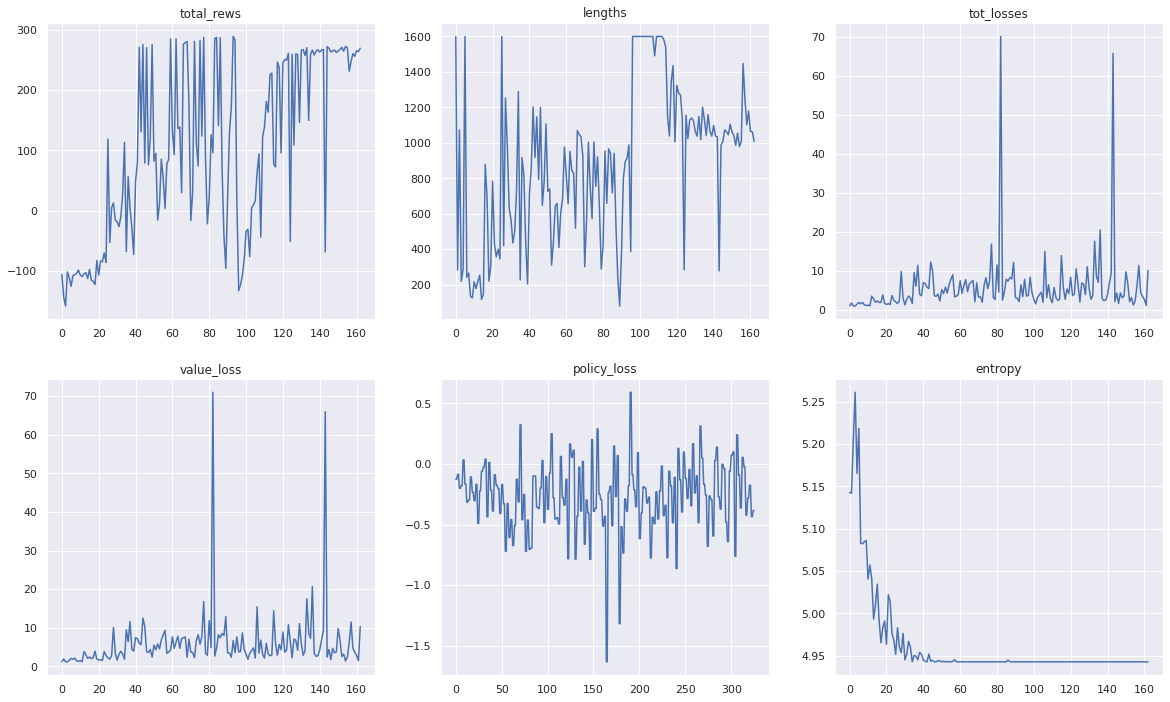

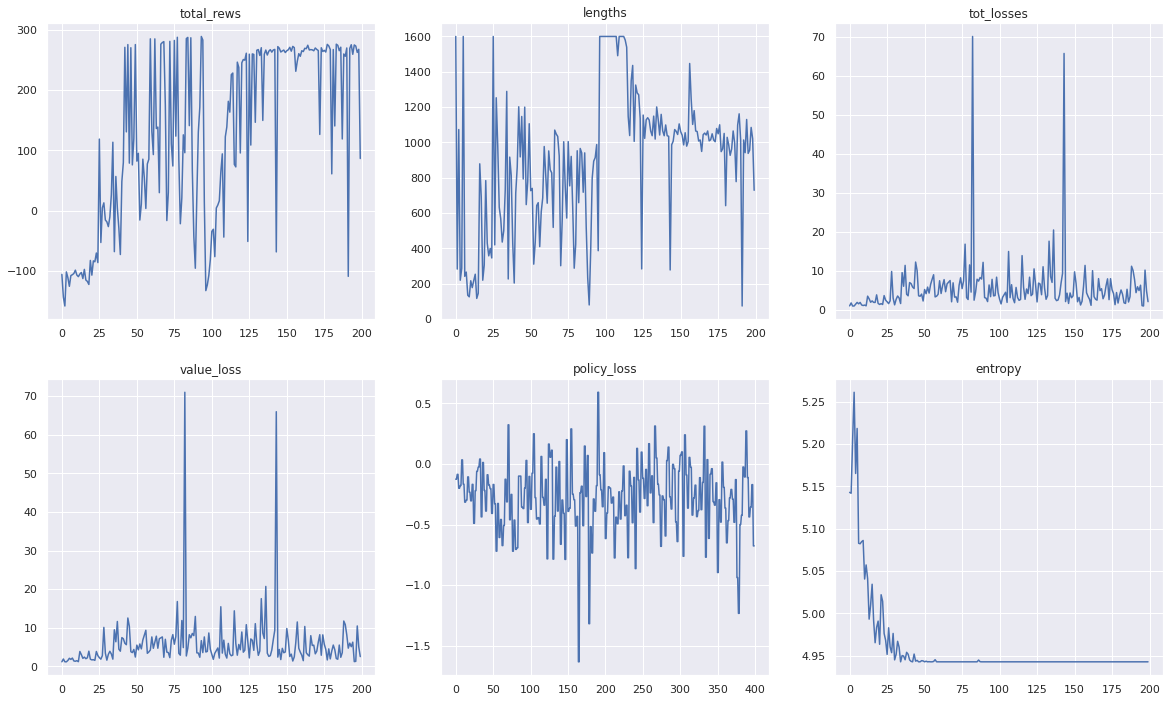

In [13]:
runner.run()

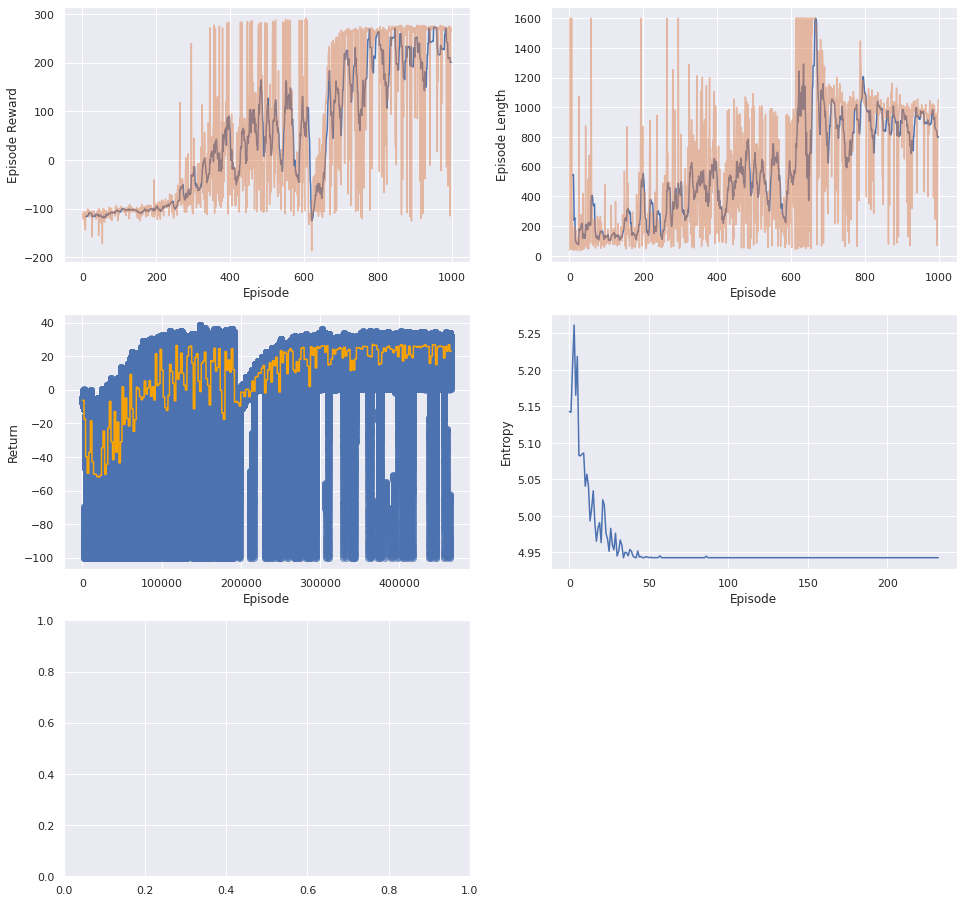

In [14]:
plot_results(runner, reward_scale=reward_scale(1))

In [15]:
agent.save_onnx_checkpoint(0, 'export')

## Visualize Agent

In [19]:
# load model from checkpoint
agent.resume_checkpoint('ckpts/checkpoint-epoch800.pth')

Loading checkpoint: ckpts/checkpoint-epoch800.pth ...
Checkpoint loaded. Resume training


In [17]:
# run agent in the envrionment
env, _, _ = create_env()
agent.model.eval()
test_environment(env=env, agent=agent)
show_video()

In [18]:
# export the ONNX actor 
agent.save_onnx_checkpoint(1, 'best')